In [20]:
import pickle

# Load the pkl file
with open('/home/zli230/projects/stateswitch/figs/neural/cache/ahc_session_results.pkl', 'rb') as f:
    data = pickle.load(f)

# View what was loaded
print(type(data))
data

<class 'list'>


[{'subject': 'sub-001',
  'session': 'ses-05',
  'pmc_switch_tc': array([-0.07055055, -0.16332452, -0.06280532,  0.2422658 ,  0.28253928,
          0.11071768,  0.1991427 ,  0.2670447 ,  0.13975954,  0.23589037,
         -0.0850478 , -0.02414162,  0.07933635, -0.2759308 , -0.04164782,
         -0.091025  , -0.13606909, -0.09362163], dtype=float32),
  'pmc_cluster_tc': array([ 0.19446777,  0.36891973,  0.35325864,  0.03840104,  0.05392467,
         -0.11040679, -0.12133271, -0.0849215 , -0.05064486,  0.0204274 ,
         -0.234436  , -0.23195533, -0.06711634,  0.03222436,  0.11565011,
          0.06166587, -0.08942582,  0.03529472], dtype=float32),
  'hipp_switch_tc': array([-1.2894587e-01,  1.3498099e-01, -2.5412166e-01,  1.0997599e-01,
         -3.2350418e-01,  3.5113561e-01, -5.6370188e-02, -5.1284879e-01,
         -4.9296141e-01, -1.7463583e-01, -1.4775474e-01, -1.8103319e-01,
         -3.8696942e-01, -5.1983321e-01, -3.5482347e-01,  3.6460376e-01,
          4.3179095e-04, -4.091689

In [21]:
import numpy as np
from scipy import stats

# Stack all session t-values into a matrix
t_matrix = np.array([d['parcel_t_values'] for d in data])
print(f"Shape: {t_matrix.shape}  (n_sessions, n_parcels)")

# One-sample t-test at each parcel (tests if mean t-value differs from 0)
group_t, group_p = stats.ttest_1samp(t_matrix, 0, axis=0)

# Handle any NaNs
group_t = np.nan_to_num(group_t, nan=0)
group_p = np.nan_to_num(group_p, nan=1.0)

print(f"Number of parcels: {len(group_t)}")
print(f"Parcels with |t| > 3: {np.sum(np.abs(group_t) > 3)}")

Shape: (18, 400)  (n_sessions, n_parcels)
Number of parcels: 400
Parcels with |t| > 3: 111


In [22]:
from nilearn import datasets
import numpy as np

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17)
    
# Convert byte labels to strings
# The atlas['labels'] list usually includes "Background" as index 0.
all_labels = [l.decode() if hasattr(l, 'decode') else str(l) for l in atlas['labels']]
roi_labels = [l for l in all_labels if l != 'Background']

[fetch_atlas_schaefer_2018] Dataset found in /home/zli230/nilearn_data/schaefer_2018

In [23]:
import pandas as pd

# Find parcels with significant group t-values
sig_indices = np.where(np.abs(group_t) > 3)[0]

df_sig = pd.DataFrame({
    'index': sig_indices,
    'label': [roi_labels[i] for i in sig_indices],
    'group_t': group_t[sig_indices],
    'group_p': group_p[sig_indices],
    'mean_t': t_matrix[:, sig_indices].mean(axis=0),
}).sort_values('group_t', ascending=False)

df_sig

,index,label,group_t,group_p,mean_t
0,2,17Networks_LH_VisCent_ExStr_3,5.829668,2.009715e-05,1.543702
93,348,17Networks_RH_ContB_PFClv_4,5.587493,3.268685e-05,1.527311
40,140,17Networks_LH_ContB_PFClv_2,5.000787,1.093979e-04,1.541886
61,204,17Networks_RH_VisCent_ExStr_5,4.716338,1.991824e-04,1.491608
60,201,17Networks_RH_VisCent_ExStr_2,4.560513,2.774629e-04,1.257187
...,...,...,...,...,...
6,31,17Networks_LH_SomMotA_8,-6.939708,2.389041e-06,-1.523982
108,397,17Networks_RH_TempPar_8,-6.980395,2.216680e-06,-1.761371
35,101,17Networks_LH_SalVentAttnB_PFCl_2,-7.515073,8.460236e-07,-1.262239
87,301,17Networks_RH_SalVentAttnA_FrMed_3,-8.492837,1.602231e-07,-1.970429


[fetch_atlas_schaefer_2018] Dataset found in /home/zli230/nilearn_data/schaefer_2018

/tmp/ipykernel_86646/1494030512.py:28: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/tmp/ipykernel_86646/1494030512.py:39: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/tmp/ipykernel_86646/1494030512.py:50: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/tmp/ipykernel_86646/1494030512.py:61: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/tmp/ipykernel_86646/1494030512.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


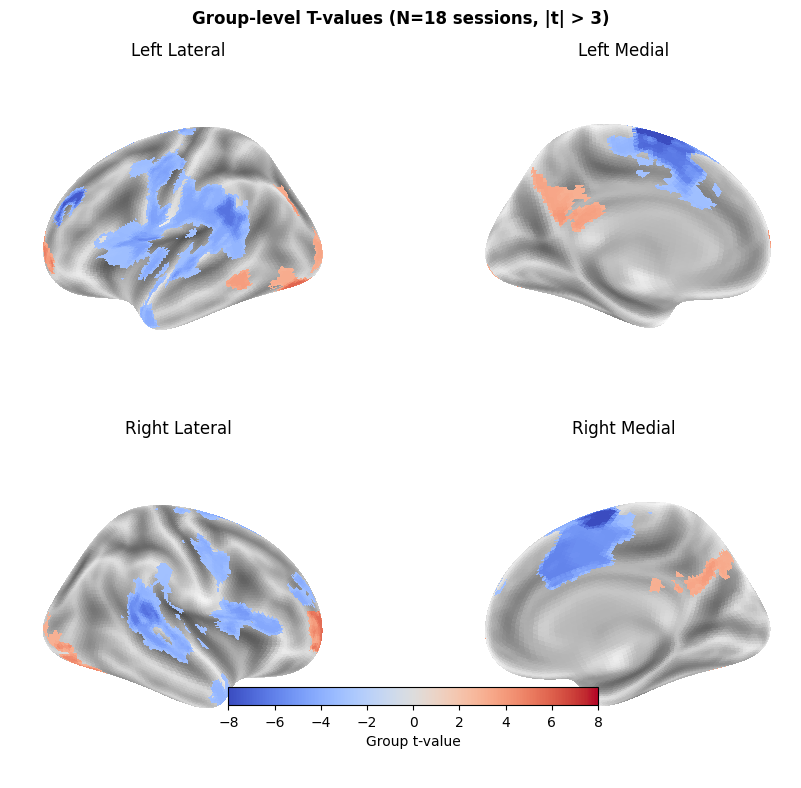

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, datasets, surface
from nilearn.maskers import NiftiLabelsMasker

# Load atlas and fsaverage surface
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17)
fsaverage = datasets.fetch_surf_fsaverage()

# Inverse transform: parcel values -> brain volume
masker = NiftiLabelsMasker(labels_img=atlas['maps'])
masker.fit()

t_map_img = masker.inverse_transform(group_t.reshape(1, -1))

# Project to surface
texture_left = surface.vol_to_surf(t_map_img, fsaverage['pial_left'])
texture_right = surface.vol_to_surf(t_map_img, fsaverage['pial_right'])

# Set parameters
vmax = 8  # Adjust based on your data
threshold = 3  # Only show |t| > 3

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': '3d'})

# Left lateral
plotting.plot_surf_stat_map(
    fsaverage['infl_left'], texture_left,
    hemi='left', view='lateral',
    bg_map=fsaverage['sulc_left'],
    cmap='coolwarm', colorbar=False,
    threshold=threshold, vmax=vmax,
    axes=axes[0, 0]
)
axes[0, 0].set_title('Left Lateral')

# Left medial
plotting.plot_surf_stat_map(
    fsaverage['infl_left'], texture_left,
    hemi='left', view='medial',
    bg_map=fsaverage['sulc_left'],
    cmap='coolwarm', colorbar=False,
    threshold=threshold, vmax=vmax,
    axes=axes[0, 1]
)
axes[0, 1].set_title('Left Medial')

# Right lateral
plotting.plot_surf_stat_map(
    fsaverage['infl_right'], texture_right,
    hemi='right', view='lateral',
    bg_map=fsaverage['sulc_right'],
    cmap='coolwarm', colorbar=False,
    threshold=threshold, vmax=vmax,
    axes=axes[1, 0]
)
axes[1, 0].set_title('Right Lateral')

# Right medial
plotting.plot_surf_stat_map(
    fsaverage['infl_right'], texture_right,
    hemi='right', view='medial',
    bg_map=fsaverage['sulc_right'],
    cmap='coolwarm', colorbar=False,
    threshold=threshold, vmax=vmax,
    axes=axes[1, 1]
)
axes[1, 1].set_title('Right Medial')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.03, pad=0.05, shrink=0.5)
cbar.set_label('Group t-value')

fig.suptitle(f'Group-level T-values (N={len(data)} sessions, |t| > {threshold})', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [25]:
# Get MNI coordinates of the PFClv parcels
from nilearn import datasets

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=2)

# Load atlas image and find centroid of parcel 348 (RH_ContB_PFClv_4)
import nibabel as nib
import numpy as np

atlas_img = nib.load(atlas['maps'])
atlas_data = atlas_img.get_fdata()
affine = atlas_img.affine

# Find voxels for parcel 349 (1-indexed in atlas)
parcel_idx = 349  # RH_ContB_PFClv_4 (add 1 because atlas is 1-indexed)
voxels = np.array(np.where(atlas_data == parcel_idx)).T

# Convert to MNI coordinates
mni_coords = nib.affines.apply_affine(affine, voxels)
centroid = mni_coords.mean(axis=0)

print(f"RH_ContB_PFClv_4 centroid (MNI): x={centroid[0]:.1f}, y={centroid[1]:.1f}, z={centroid[2]:.1f}")

[fetch_atlas_schaefer_2018] Dataset found in /home/zli230/nilearn_data/schaefer_2018

RH_ContB_PFClv_4 centroid (MNI): x=27.5, y=59.2, z=2.8


In [27]:
# masker = NiftiLabelsMasker(labels_img=atlas['maps'])
# masker.fit()

# print(f"Number of labels (masker.labels_): {len(masker.labels_)}")
# print(f"First few labels: {masker.labels_[:5]}")
# print(f"Last few labels: {masker.labels_[-5:]}")
masker = NiftiLabelsMasker(labels_img=atlas['maps'], background_label=0)
masker.fit()
print(len(masker.labels_))  # Should now be 400

401
